In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit

In [24]:
def ReLU(input):
    return np.maximum(input, 0)
def leaky_ReLU(input):
    return np.maximum(0.03 * input, input)
def Linear(input):
    return input
def Sigmoid(input):
    return 1 / (1 + np.exp(-input))
def Swish(input):
    return input * Sigmoid(input)
def Tanh(input):
    return np.tanh(input)
def ReLU_de(input):
    return (input > 0) * 1
def leaky_ReLU_de(input):
    return np.where(input > 0, 1, 0.03) 
def Linear_de(input):
    return 1
def Sigmoid_de(input):
    return np.exp(input)/ np.square(np.exp(input) + 1)
def Swish_de(input):
    return Swish(input) + Sigmoid(input)*(1 - Swish(input))
def Tanh_de(input):
    return (1 - np.power(np.tanh(input), 2))
def CrossEntropy(predict, target):
    return np.mean(-target * np.log(predict))
def MSE(predict, target):
    loss = np.square(target - predict)
    m = target.shape[1]
    cost = 1 / m * np.sum(loss)
    return np.squeeze(cost)
def MSEGrad(target, predict):
    delta = -2 * (target - predict)
    return delta
def Soft_Max(input):
    return np.exp(input) / np.sum(np.exp(input), axis = 0)
def Soft_Max_de(input):
    return 1
def deriative_func(func):
    if func.__name__ == "ReLU":
        return (ReLU_de)
    if func.__name__ == "leaky_ReLU":
        return (leaky_ReLU_de)
    if func.__name__ == "Linear":
        return (Linear_de)
    if func.__name__ == "Sigmoid":
        return (Sigmoid_de)
    if func.__name__ == "Swish":
        return (Swish_de)
    if func.__name__ == "Tanh":
        return (Tanh_de)

In [25]:
def fft_conv(img_matrix, filter):
    img_fft = np.fft.fft2(img_matrix)
    kernel_fft = np.fft.fft2(filter, s=img_matrix.shape)
    res = img_fft * kernel_fft
    return np.fft.ifft2(res).real
def fftZ_conv(X, K, B):
    output = np.zeros((X.shape[0], K.shape[0],X.shape[2], X.shape[3]))
    for i in range (X.shape[0]):
        for j in range (K.shape[0]):
            sum = 0
            for k in range (X.shape[1]):    
                sum += fft_conv(X[i][k],K[j][k])
            output[i][j] = sum + B[j]   
    return output
def conv_3d(input, kernel, kernel_size, n_kernels):
    output = np.zeros((n_kernels, input.shape[0], input.shape[1], input.shape[2]))
    for i in range (n_kernels):
        for k in range(input.shape[0]):
            output[i][k] = fft_conv(input[k], kernel[i])
    return output
def dK_convolution(X, dZ, K_shape):                                              
    dZ_size = dZ.shape[-1]
    dK = np.zeros((dZ.shape[1], X.shape[1],K_shape[2], K_shape[3]))
    for i in range (X.shape[0]):
        dK += np.fft.ifft2(conv_3d(X[i], dZ[i], K_shape[2],K_shape[0]), s = K_shape[2:]).real
    return dK
def dX_convolution(dZ, K):
    kernel_size = K.shape[-1]
    dX = np.zeros((dZ.shape[0], K.shape[1],dZ.shape[2], dZ.shape[3]))
    for i in range (dZ.shape[0]):
        for j in range (K.shape[0]):
            for k in range (K.shape[1]):
                dX[i][k] = fft_conv(dZ[i][j],np.rot90(K[j][k], 2))
    return dX

In [26]:
def max_pooling(input, pool_size = 2):
    pool_stride = pool_size
    conv2 = np.zeros((1, (input.shape[1] - pool_size)//pool_stride + 1))
    for i in range(0,input.shape[0] - pool_size + 1, pool_stride):
        row = np.array([])
        for k in range(0,input.shape[1] - pool_size + 1, pool_stride):
            res = np.max(input[i : i + pool_size,k : k + pool_size])
            row = np.append(row, res).reshape(1, -1)
        conv2 = np.vstack((conv2, row))
    conv2 = conv2[1:,:]
    return conv2
def avg_pooling(input, pool_size = 2):
    pool_stride = pool_size
    conv2 = np.zeros((1, (input.shape[1] - pool_size)//pool_stride + 1))
    for i in range(0,input.shape[0] - pool_size + 1, pool_stride):
        row = np.array([])
        for k in range(0,input.shape[1] - pool_size + 1, pool_stride):
            res = np.mean(input[i : i + pool_size,k : k + pool_size])
            row = np.append(row, res).reshape(1, -1)
        conv2 = np.vstack((conv2, row))
    conv2 = conv2[1:,:]
    return conv2
def pool_3d(input, pool_size, pool_type):
    output = np.zeros((input.shape[0], (input.shape[1] - pool_size) // pool_size + 1, (input.shape[2] - pool_size) // pool_size + 1))
    # print('P output shape: ', output.shape)
    for i in range (output.shape[0]):
        output[i] = pool_type(input[i], pool_size = pool_size)
    return output

In [27]:
def maxpool_de(dP, P, C, pool_size):
    pool_stride = pool_size
    dC = np.copy(C)
    for i in range(0,C.shape[0] - pool_size + 1, pool_stride):
        for k in range(0,C.shape[1] - pool_size + 1, pool_stride):
            dC[i : i + pool_size,k : k + pool_size][dC[i : i + pool_size,k : k + pool_size] != P[i // pool_size,k // pool_size]] = 0
            dC[i : i + pool_size,k : k + pool_size][dC[i : i + pool_size,k : k + pool_size] == P[i // pool_size,k // pool_size]] = dP[i // pool_size,k // pool_size]
    if dC.shape[0] / pool_size != 0:
        dC[-1,:] = 0 
    if dC.shape[1] / pool_size != 0:
        dC[:,-1] = 0 
    return dC

def avgpool_de(dP, P, C, pool_size):
    pool_stride = pool_size 
    dC = np.copy(C)
    for i in range(0,C.shape[0] - pool_size + 1, pool_stride):
        for k in range(0,C.shape[1] - pool_size + 1, pool_stride):
            dC[i : i + pool_size,k : k + pool_size] = dP[i // pool_size,k // pool_size] / (pool_size ** 2)
    # BAD CODE
    if dC.shape[0] / pool_size != 0:
        dC[-1,:] = 0 
    if dC.shape[1] / pool_size != 0:
        dC[:,-1] = 0 
    return dC
def pool_de_3d(dP, P, C, pool_size, pool_de):
    res = []
    for i in range(P.shape[0]):
        res.append(pool_de(dP[i], P[i], C[i], pool_size))
    return np.array(res)

In [28]:
class Conv_layer:
    def __init__(self, X_shape, kernel_size, n_kernels):
        self.n_kernels = n_kernels
        self.kernel_size = kernel_size
        self.X_shape = X_shape
        self.output_shape = (X_shape[0], n_kernels, X_shape[2], X_shape[3])
        self.kernel_shape = (n_kernels, X_shape[1],kernel_size, kernel_size)
        self.K = np.random.randn(*self.kernel_shape)
        self.B = np.random.randn(n_kernels, self.output_shape[2], self.output_shape[3])
        self.dK = None
        self.dB = None
    def forward(self, X):
        self.X = X
        self.dX = np.copy(X)
        Z = fftZ_conv(X, self.K, self.B)
        return ReLU(Z)
    def backward(self, dC):
        dZ = ReLU_de(dC)
        self.dB = np.sum(dZ, axis = 0)
        self.dK = dK_convolution(self.X, dZ, self.kernel_shape)
        self.dX = dX_convolution(dZ, self.K)
        return self.dX
    def update(self, learning_rate = 0.0001):
        self.B -= learning_rate * self.dB
        self.K -= learning_rate * self.dK

class Pool_layer:
    def __init__(self, input_shape, pool_size, pool_type = 'max'):
        self.pool_size = pool_size
        self.input = None
        self.output_shape = (input_shape[0], input_shape[1], (input_shape[2] - pool_size) // pool_size + 1, (input_shape[3] - pool_size) // pool_size + 1)
        self.output = np.zeros(self.output_shape)
        if pool_type == 'max':
            self.pool = max_pooling
            self.pool_de = maxpool_de
        else:
            self.pool = avg_pooling
            self.pool_de = avgpool_de
    def forward(self, input):
        for i in range (self.output_shape[0]):
            self.output[i] = pool_3d(input[i], self.pool_size, self.pool)
        return self.output
    def backward(self, dP, P, C):
        res = []
        for i in range (self.output_shape[0]):
            res.append(pool_de_3d(dP[i], P[i], C[i], self.pool_size, self.pool_de))
        return np.array(res)

In [29]:
class Reshape:
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
    def forward(self, input):
        return input.reshape(self.output_shape)
    def backward(self, output):
        return output.reshape(self.input_shape)

In [30]:
class FcSub_Layer:
    def __init__(self, row, col, act_func, isoutputlayer = False):
        self.isoutputlayer = isoutputlayer
        self.left_layer_output = None
        self.weight = 0.01 * np.random.randn(col, row)
        self.bias = np.zeros([col, 1])
        self.dW = None
        self.db = None
        self.activationForward = act_func
        self.activationBackward = deriative_func(act_func)
        self.input = None
        self.d_input = None
        self.output = None
        
    def forward(self, input_data):
        self.left_layer_output = input_data
        self.input =  np.dot(self.weight, input_data) + self.bias
        self.output = self.activationForward(self.input)
        return self.output
    
    def backward(self, d_input):
        m = self.left_layer_output.shape[1]
        self.dW = 1 / m * np.dot(d_input, self.left_layer_output.T)
        self.db = 1 / m * np.sum(d_input, axis=1, keepdims=True)
        delta = 1 / m * np.dot(self.weight.T, d_input)
        return delta

    def update(self, learning_rate):
        self.weight -= learning_rate * self.dW  
        self.bias -= learning_rate * self.db 

class FullyConnected:
    def __init__(self, n_nodes_list, hiddenlayers_actfunc):
        self.pred_his = []
        self.layers = []
        for i in range (len(n_nodes_list) - 1):
            self.layers.append(FcSub_Layer(row = n_nodes_list[i], col=n_nodes_list[i + 1], act_func=hiddenlayers_actfunc))
        self.layers[-1].activationForward = Soft_Max
        self.layers[-1].activationBackward = Soft_Max_de
        self.cost_his = []
    def forward(self, input):
        x = np.copy(input)
        for layer in self.layers:
            x = layer.forward(x)
        return x
    def backward(self, target, predict):
        delta = predict - target
        for layer in reversed(self.layers):
            d_input = delta * layer.activationBackward(layer.output)
            delta = layer.backward(d_input)
        return delta
    def update(self, learning_rate = 0.01):
        for layer in self.layers:
            layer.update(learning_rate)
    def fit(self, input_matrix, target, learning_rate, epochs, lr_down = True, lr_decay = 10):
        for i in range (epochs):
            predict = self.forward(input_matrix)
            self.backward(target, predict)
            self.update(learning_rate= learning_rate)
            if lr_down:
                if i % 1000 == 0:
                    learning_rate -= learning_rate / lr_decay
            if (i + 1) % 10 == 0:
                self.pred_his.append(predict)
                self.cost_his.append(CrossEntropy(predict, target)) 
        return predict

In [31]:
class CNN:
    def __init__(self, input_shape, output_shape):
        self.conv = Conv_layer(input_shape, 5, 5)
        self.pool = Pool_layer(self.conv.output_shape, 4, 'max')
        self.rs = Reshape(self.pool.output_shape, (self.pool.output_shape[1] * self.pool.output_shape[2] * self.pool.output_shape[3], input_shape[0]))
        self.flc = FullyConnected([self.rs.output_shape[0],10, 10, output_shape[0]], Tanh)
        self.cost_his = []
    def train(self,input, target, learning_rate, epochs, lr_decay):
        for i in range (epochs):
            C = self.conv.forward(input)
            P = self.pool.forward(C)
            f = self.rs.forward(P)
            if i%100==0:
                learning_rate = learning_rate - learning_rate/lr_decay
            predict = self.flc.forward(f)
            df = self.flc.backward(predict=predict, target=target)
            dP = self.rs.backward(df)
            dC = self.pool.backward(dP, P, C)
            dX = self.conv.backward(dC)
            self.flc.update(learning_rate)
            self.conv.update(learning_rate)
            self.cost_his.append(CrossEntropy(predict, target))




In [32]:
X_train = np.loadtxt('train_X.csv', delimiter = ',')
Y_train = np.loadtxt('train_label.csv', delimiter = ',')
s = np.arange(0, len(X_train), 1)
np.random.shuffle(s)
X_train = X_train[s].T
Y_train = Y_train[s].T
X_test = np.loadtxt('test_X.csv', delimiter = ',').T
Y_test = np.loadtxt('test_label.csv', delimiter = ',').T
# print("shape of X_train :", X_train.shape)
# print("shape of Y_train :", Y_train.shape)
# print("shape of X_test :", X_test.shape)
# print("shape of Y_test :", Y_test.shape)

imgs = []
n_imgs = 20
for i in range (n_imgs):
    imgs.append(X_train[:, i].reshape(1,28,28))

imgs = np.array(imgs) / 255
# print(imgs.shape)

0.0004986610690415105
Time:  171.75131950000002


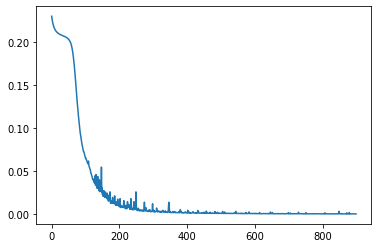

In [33]:
start = timeit.default_timer()

#Your statements here
CNN = CNN(imgs.shape, Y_train[:,:n_imgs].shape)
CNN.train(imgs, Y_train[:, :n_imgs], 0.9 , 900, lr_decay=20)

plt.plot(CNN.cost_his)
print(CNN.cost_his[-1])
stop2 = timeit.default_timer()

print('Time: ', stop2 - start)  